In [1]:
import os
import time
import random
import json
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

from sklearn import metrics
from collections import defaultdict
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

def TFPN(ground_truth, prediction):
    TFPN = ""
    if ground_truth:
        if prediction:
            TFPN = "TP"
        else:
            TFPN = "FN"
    else:
        if prediction:
            TFPN = "FP"
        else:
            TFPN = "TN"
    return(TFPN)


In [2]:
vrc_reactivity = pd.read_table("VRC_reactivity.csv", sep=",", index_col = 0)

In [3]:
vrc_reactivity

,reactive samples,min 1 sample reactive,min 2 sample reactive,min 5 sample reactive
u_pep_id,,,,
AllergomeL_001_ATGGGGTTTATTACCAAGGCGATCCCTATCGTCCTCGCCGCCCTGAGTAC,0,0,0,0
AllergomeL_001_AACATGTCTTTAGGTGGTCCGCGCTCAGAGGCATCGAATCAGGCGGCCAA,5,1,1,1
AllergomeL_001_GCTGCGGGGAATGAAAATATGGACGCACAACATTCAAGTCCTGCAAGCGA,23,1,1,1
AllergomeL_001_GACGATGGTAAGGCGGACTTTTCTAACTATGGGGCAGTAGTGGACGTCTA,15,1,1,1
AllergomeL_001_GGCGGGAGTACTGACACGTTGTCTGGCACGTCCATGGCATCACCGCATGT,6,1,1,1
...,...,...,...,...
HumanLarma_003_GTCCGTAAAGCTAACGAGCGTTGTGAACGCTGTTGTGTTAGCATACAGGA,0,0,0,0
HumanLarma_003_AGCTTACATAAAGACTTTGCTTTTTACCTGGGCAAAGGCGGGTACTTTTC,3,1,1,0
HumanLarma_003_ATCAGTCTGCGCCTGCCGAATTTAGAAGCCCCGAGCCATATCAGTGGATC,0,0,0,0


In [7]:
tile_anno = pd.read_csv("phipseq_0068_Hits_foldchange_annotated.tsv", sep='\t', index_col = 0)
tile_anno = tile_anno.drop(tile_anno.columns[9:], axis = 1)
ebv = tile_anno[tile_anno["taxon_species"] == "Epstein-Barr virus"]

/home/anna/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1,2,3,4,6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
all_species = set(tile_anno["taxon_species"])
all_species = {x for x in all_species if x==x}

In [10]:
# FIND WHERE I MADE THIS! It should go here

with open('tile_probabilities.json') as json_file:
    rf_probabilities = json.load(json_file)

In [11]:
vrc_reactivity["min 1 sample reactive"].value_counts()

0    385108
1    210984
Name: min 1 sample reactive, dtype: int64

In [13]:
ebv_epi_probabilities_rf = {}

for tile in ebv.index:
    ebv_epi_probabilities_rf[tile] = rf_probabilities[tile]   

In [13]:
def scoring_tile(pred_vec_rf, version):
    v = np.array(pred_vec_rf)          
    if "mean(>.5)" in version:
        pos_only = np.maximum(0,v-0.5)
        no_epi = sum(pos_only > 0)
        if no_epi > 0:
            return(0.5 + (sum(pos_only)/no_epi))
        else:
            return(np.mean(v))
    elif "mean" in version:
        return(np.mean(v))
    elif "median" in version:
        return(np.median(v))
    elif "1-variance" in version:
        return(1-np.var(v))
    elif "90percentile" in version:
        return(np.percentile(v,90))
    elif "max" in version:
        return(max(v))
    else:
        return(1)

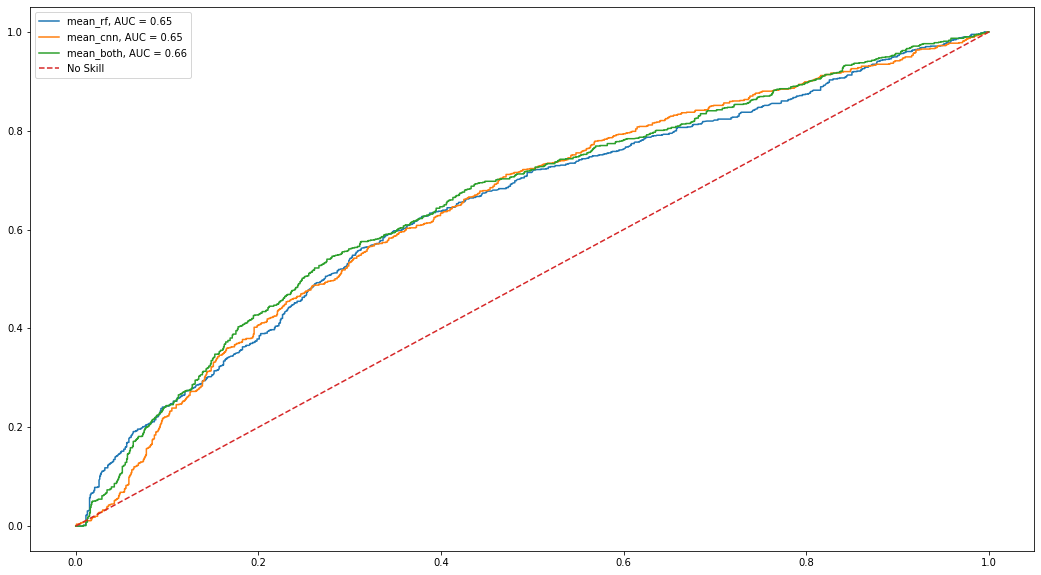

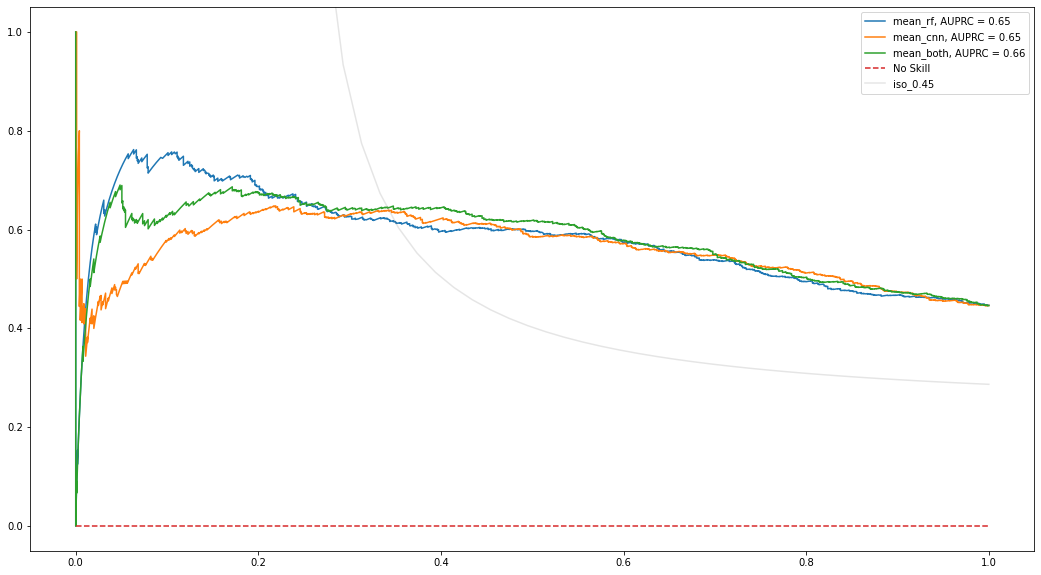

In [18]:
matplotlib.rcParams['figure.figsize'] = [18, 10]

cutoff_minsamplesVRC = 2
ept = ebv_epi_probabilities_rf

comp_df_t = pd.DataFrame({"VRC reactive" : [vrc_reactivity.loc[k,"reactive samples"] >= cutoff_minsamplesVRC for k in ept.keys()]})
comp_df_t["VRC reactive"] = comp_df_t["VRC reactive"].astype(int)
fig_roc, ax_roc = plt.subplots()

for function in ["mean"]:#, "var and mea", "max","median","1-variance","90percentile","mean(>.5)"]:
    scoring_func = "rf_" + predictor
    score_label = "tile_score_"+str(scoring_func)
    comp_df_t[score_label] = [scoring_tile(ept[k],scoring_func) for k in ept.keys()]
    fpr, tpr, _ = roc_curve(comp_df_t["VRC reactive"], comp_df_t[score_label])
    auc_score = round(metrics.roc_auc_score(comp_df_t["VRC reactive"], comp_df_t[score_label]) ,2)       
    ax_roc.plot(fpr, tpr, label=scoring_func + ", AUC = " + str(auc_score))

ax_roc.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.ylim([-0.05, 1.05])
ax_roc.legend()
ax_pr.legend()
plt.show()
#fig_roc.savefig('ebv_existing_tiles_roc.pdf')  

In [15]:
comp_df_t["VRC reactive"].value_counts()

0    1254
1    1009
Name: VRC reactive, dtype: int64